In [1]:
# You can ignore this, it disables unnecessary warnings & pretty-prints arrays
import cvxpy as cvx
import numpy as np
import warnings
ndigits = 3
fmt_x = lambda x, hspace: (str(x) if np.issubdtype(x, int) else f'%.{ndigits}f' % np.round(x, ndigits)).ljust(1+hspace + (2*ndigits if not np.issubdtype(x, int) else 0))
def pprint(arr):
    hspace = 0 if arr.size == 1 else len(str(round(max(arr.flatten(), key=lambda k: len(str(round(k)))))))
    return str(arr.item()) if arr.size == 1 else ''.join(fmt_x(x, hspace) for x in arr) if (arr.ndim == 1) else '\n'.join('\n'.join(''.join(fmt_x(x, hspace) for x in arr.reshape(*arr.shape[0:2], -1)[r, :, i]) for r in range(arr.shape[0])) for i in range(np.prod(arr.shape[2:], dtype=int)))
np.set_string_function(pprint, repr=False)
cvx.disable_warnings()
warnings.filterwarnings('ignore')

# Learning sudoku by doing gradient descent on a linear program
["OptNet: Differentiable Optimization as a Layer in Neural Networks"](https://arxiv.org/pdf/1703.00443) describes a way to differentiate linear programs, which is an interesting thing one might think to do (I go into some detail about this in the discussion section towards the end). [`cvxpylayers`](https://github.com/cvxpy/cvxpylayers) is a python package implementing their ideas using the `cvxpy` backend, and I'm going to try and use that implementation to train a model to learn sudoku. You can download the Jupyter notebook [here](https://github.com/mxkopy/sudoku/blob/main/sudoku.ipynb), which includes a bunch of printing/visualization code that I've left out.

## Introduction
The general motivation and background for this topic is summarized [here](https://en.wikipedia.org/wiki/Constrained_conditional_model), with the "Integer linear programming for natural language processing applications" section being especially relevant. 

Constraint programming lets you find the optimal values of a function under some constraints. In general, we specfiy the dependent/output *variables* we're solving for, an *objective* function we'd like to minimize or maximize, and the *constraints* that define the set of solutions; then we call a solver to do math we don't understand. If there are no solutions, the LP is *infeasible*, and if there are infinite solutions, the LP is *unbounded*. [There's a lot of good theory behind this stuff](https://www.zib.de/userpage/groetschel/pubnew/paper/groetschellovaszschrijver1988.pdf) but practically, a solver will give you a solution or throw an error if your problem is infeasible, unbounded, or otherwise inadmissible.

Here I use `cvxpy` to find the smallest value of $x + y$ under the constraints that $4x - y = 1$ and $x, y$ are nonnegative integers. It turns out $x=1$ and $y=3$. 

In [ ]:
import cvxpy as cvx
import numpy as np


# Set up output variables
x = cvx.Variable(integer=True)
y = cvx.Variable(integer=True)

# Set up model parameters
a = 4
b = -1

# Set up problem constraints & objective
constraints = [a*x + b*y == 1, x >= 0, y >= 0]
objective   = cvx.Minimize(cvx.sum(x))
problem     = cvx.Problem(objective, constraints)

# Find a solution satisfying the constraints
problem.solve()
x.value.item(), y.value.item()

(1.0, 3.0)

For things that can be totally defined by a set of rules, this is very useful. For example, we don't need to know anything apart from the rules of sudoku to make, complete, or verify a puzzle. By writing the rules as a set of constraints, we can use linear programming to do this naturally. The rules are that every row, column, and 3x3 square (what I've learned is called a 'chute') contains each number 1 through 9.

It's a bit tricky to do this using a 9x9 grid. Instead, I'll use a one-hot encoding, as in the OptNet paper. This means we have a 9x9x9 tensor indexed by row, column, and digit: `board[row, col, digit]`. If we want to put a 1 in the top left corner of the board, we'd write `board[0, 0, 0] = 1`; and to put a 2 directly to the right of it we'd write `board[0, 1, 1] = 1`.

The rule 'each row has one of each digit' can be written in python-constraint form as 

`sum(board[row, :, digit]) == 1 for all rows & digits`;

for columns it'd be 

`sum(board[:, col, digit]) == 1 for all columns & digits`.

Since there's only one digit in each cell, we should also write 

`sum(board[row, col, :]) == 1 for all rows & columns`.

In [ ]:
# Set up one-hot output board
board = cvx.Variable((9, 9, 9), boolean=True)

# Set up one-hot sudoku constraints
rows_ct   = [cvx.sum(board[r, :, d]) == 1 for r in range(9) for d in range(9)] # Each row has one of each digit 
cols_ct   = [cvx.sum(board[:, c, d]) == 1 for c in range(9) for d in range(9)] # Each col has one of each digit
nums_ct   = [cvx.sum(board[r, c, :]) == 1 for r in range(9) for c in range(9)] # Each cell has one digit
chutes_ct = [cvx.sum(board[r*3:(r+1)*3, c*3:(c+1)*3, d]) == 1 for r in range(3) for c in range(3) for d in range(9)] # ditto w/ chutes

To solve from an initial solution or *hint*, we'd find the board closest to it that satisfies the constraints. Since they're both just vectors, we can just minimize their distance. Then, the objective should be to find a board such that `sum((board - hint)^2)` is minimal.

In [ ]:
# Set up initial solution/input board
input = cvx.Parameter((9, 9, 9))

# Set up the objective & constraints
objective = cvx.Minimize(cvx.sum_squares(board - input)) # Find board closest to initial solution
constraints = rows_ct + cols_ct + nums_ct + chutes_ct  # Constraints describing solved sudoku

We could see if there's a sudoku where the first row is the numbers 1 -> 9 by setting that as our hint:

In [ ]:
# Set initial row to be 1 -> 9
input.value = np.zeros((9, 9, 9))
for c in range(9):
    input.value[0, c, c] = 1

# Set problem & solve
sudoku = cvx.Problem(objective, constraints)
sudoku.solve()

# Make the solution pretty & readable
def to_decimal(board):
    from itertools import product
    board = board if isinstance(board, np.ndarray) else board.value
    decimal = np.zeros((9, 9), dtype=int)
    for r, c, d in product(range(9), repeat=3):
        decimal[r, c] += (d+1) * board[r, c, d]
    boardstr = str(decimal.astype(int))
    s_rows = boardstr.split('\n')
    nr = len(s_rows)
    nc = len(s_rows[0]) + 1
    r = lambda i : (i // nc) // (nr // 9)
    c = lambda i : (i % nc) // (nc // 9)
    in_corner = lambda i: (r(i) < 3 or r(i) >= 6) and (c(i) < 3 or c(i) >= 6)
    in_middle = lambda i: 3 <= r(i) and r(i) < 6 and 3 <= c(i) and c(i) < 6
    s = ''.join([f'\033[94m{c}\033[0m' if in_corner(i) or in_middle(i) else f'{c}' for i, c in enumerate(boardstr)])
    print(s)

to_decimal(board)

1 2 3 4 5 6 7 8 9 
5 9 4 2 8 7 6 1 3 
7 6 8 1 9 3 5 4 2 
2 1 7 9 6 4 8 3 5 
8 4 9 5 3 2 1 6 7 
6 3 5 7 1 8 2 9 4 
4 7 1 6 2 9 3 5 8 
9 8 6 3 7 5 4 2 1 
3 5 2 8 4 1 9 7 6 


Linear programming (and constraint programming in general) seems to provide some powerful tools related to reasoning. By being creative with constraints, one can prove statements about sudoku to be true, or otherwise find a counterexample. Add a constraint that describes the set of counterexamples, then try to solve the resulting problem -- if it's infeasible, there aren't any counterexamples and the statement is true; if it's feasible then any solution is a counterexample.

Consider the statement 'a diagonal (starting at the top left) of a sudoku board has less than six unique numbers'. The diagonal has to have at least three unique numbers since a chute will have a repeat otherwise, but arguments going the other way don't seem as straightforward. 

I'll test this statement by trying to find a counterexample, e.g. a sudoku with six numbers present and three missing on the diagonal. The particular numbers don't matter, so we can just pick 1 -> 6 and 7 -> 9 respectively. Then the counterexample-constraint should ensure that digits 1 -> 6 contain at least one entry on the diagonal, and digits 7 -> 9 contain none.

In [ ]:
# Counterexample - a diagonal with exactly six unique numbers
diagonal_example_ct_1 = [cvx.sum([board[r, r, d] for r in range(9)]) >= 1 for d in range(6)]
diagonal_example_ct_2 = [cvx.sum([board[r, r, d] for r in range(9)]) == 0 for d in range(6, 9)]
cvx.Problem(cvx.Minimize(0), constraints + diagonal_example_ct_1 + diagonal_example_ct_2).solve()
to_decimal(board)

6 8 9 4 2 7 5 3 1 
5 3 4 9 6 1 7 8 2 
2 7 1 5 8 3 4 9 6 
1 4 7 6 9 2 3 5 8 
9 2 3 8 1 5 6 7 4 
8 5 6 7 3 4 1 2 9 
7 6 8 1 5 9 2 4 3 
3 1 5 2 4 8 9 6 7 
4 9 2 3 7 6 8 1 5 


This is a false statement, since here's a valid sudoku with only numbers 1 -> 6 on the diagonal. In fact, a diagonal can have any number of unique digits $\geq$ three. 

In [120]:
for n in range(1, 10):
    diagonal_example_ct_1 = [cvx.sum([board[r, r, d] for r in range(9)]) >= 1 for d in range(n)]
    diagonal_example_ct_2 = [cvx.sum([board[r, r, d] for r in range(9)]) == 0 for d in range(n, 9)]
    diagonal_sudoku = cvx.Problem(cvx.Minimize(0), constraints + diagonal_example_ct_1 + diagonal_example_ct_2)
    diagonal_sudoku.solve()
    if diagonal_sudoku.status in ['infeasible', 'unbounded']:
        print(f'{n}: no examples')
    else:
        print(f'{n}: yes examples')

1: no examples
2: no examples
3: yes examples
4: yes examples
5: yes examples
6: yes examples
7: yes examples
8: yes examples
9: yes examples


I hope this illustrates some of the allure of linear programs. They implement set logic, where sets are defined *descriptively* by constraints. We can test whether something is in a set, whether a set is empty, (sometimes if we're creative enough) if it's in the complement, and so forth. And we don't need to compare anything directly, instead we use the set's *description* (or properties, loosely speaking). On one hand, this might be limited to situations where thinking about sets is useful. On the other hand, sets are often useful.

To drive this point further, I've made a linear program for finding hints with solutions guaranteed to be unique. The constraint for 'uniqueness' here is that each cell in the hint has at least 8 digits among its row, column, and/or chute (i.e. each cell must have a unique solution).

In [ ]:
from itertools import product

class Sudoku:

    # Makes a sudoku uniquely defined by a hint of size n
    def unique_hint_of_length_n(self, n):
        minimum_hint = cvx.Variable((9, 9, 9), boolean=True)
        hint_ct = [self.board >= minimum_hint, cvx.sum(minimum_hint) == n]
        uniqueness_ct = []
        for y in range(0, 9, 3):
            for x in range(0, 9, 3):
                for r in range(y, y+3):
                    for c in range(x, x+3):
                        uniqueness_ct += [cvx.sum(minimum_hint[y:y+3, x:x+3, :]) + cvx.sum(minimum_hint[:, c, :]) + cvx.sum(minimum_hint[r, :, :]) >= 8]
        problem = cvx.Problem(cvx.Minimize(cvx.sum_squares(minimum_hint - self.random_ones())), constraints=self.constraints + hint_ct + uniqueness_ct)
        problem.solve()
        if problem.status not in ['infeasible', 'unbounded']:
            return minimum_hint.value.copy()

    # Other stuff useful for later
    def __init__(self):
        self.board = cvx.Variable((9, 9, 9), boolean=True)
        self.constraints\
        = [cvx.sum(self.board[r, :, d]) == 1 for r in range(9) for d in range(9)]\
        + [cvx.sum(self.board[:, c, d]) == 1 for c in range(9) for d in range(9)]\
        + [cvx.sum(self.board[r, c, :]) == 1 for r in range(9) for c in range(9)]\
        + [cvx.sum(self.board[3*r:3*(r+1), 3*c:3*(c+1), d]) == 1 for r in range(3) for c in range(3) for d in range(9)]
        self.make_objective = lambda: cvx.Minimize(cvx.sum_squares(self.board - self.random_ones()))

    def complete_solution(self, hint):
        hint_ct = [self.board[r, c, d] == hint[r, c, d] for r, c, d in product(range(9), repeat=3) if hint[r, c, d] == 1]
        sudoku = cvx.Problem(self.make_objective(), self.constraints + hint_ct)
        sudoku.solve()
        if sudoku.solution.status not in ['infeasible', 'unbounded']:
            return self.board.value.copy()

    def random_ones(self, n_random=3):
        random_ones = np.zeros((9, 9, 9), dtype=int)
        for _ in range(n_random):
            random_ones.reshape(-1)[np.random.randint(9*9*9)] = 1
        return random_ones

    def generate(self):
        sudoku = cvx.Problem(self.make_objective(), self.constraints)
        sudoku.solve()
        if sudoku.solution.status not in ['infeasible', 'unbounded']:
            return self.board.value.copy()

to_decimal(Sudoku().unique_hint_of_length_n(27))

0 3 0 0 0 6 9 0 0 
0 0 9 0 7 8 0 0 0 
6 0 0 0 0 0 0 3 7 
5 0 4 0 0 0 2 0 0 
0 0 8 5 0 0 3 0 0 
0 0 0 4 1 0 0 0 5 
3 0 0 8 0 0 0 2 0 
0 0 0 0 9 4 6 0 0 
0 5 2 0 0 0 0 4 0 


## Experiment
Naturally, we'll want to apply this as a deep learning model, so I don't have to think too hard when I'm figuring out how to translate some idea into a constraint.

`cvxpylayers` lets us do this by putting an LP solver into a neural network layer. It's counterintuitive as to what exactly that would entail, since linear programs aren't usually represented as functions with inputs and outputs. Generally, the inputs to a linear program would be an objective function we want to minimize $f(x)$ with some functions representing constraints in the form $g(x) \leq 0$ or $h(x) = 0$. The output is an optimal solution $x_{\text{opt}}$ minimizing $f$ while $g(x) \leq 0$ and $h(x) = 0$. It turns out that, though under some assumptions, whether $x$ is optimal depends on the derivatives of $f(x)$, $g(x)$, and $h(x)$. Perhaps some [talented mathematicians](https://arxiv.org/pdf/1703.00443) can then figure out the derivative of $x_{\text{opt}}$ from $f'$, $g'$, and $h'$.

Appreciating this result, we can train a model to solve incomplete sudokus as in the OptNet paper (this one is larger >:)). As a linear program, it tries to complete a hint by finding a solution closest to it under learned constraints; as a neural network it updates these constraints using the error between the completed hint and the actual solution.

A sort of brute force way to approach this is to learn $g$ and $h$ as rules in the form of a $(9 \cdot 9 \cdot 9)^2$ tensor relating every cell to a possible game state. This is actually not too big of a number for modern hardware and is an ideal approach, since we might accidentally cheat and encode some prior information about the game trying to be more efficient. Unfortunately, `cvxpy` doesn't seem to be able to handle matrices with $(9 \cdot 9 \cdot 9)^2$ floats, so I've devised a way of splitting up the workload among multiple layers in parallel. This probably has to do with `cvxpy` being a [compiler](https://www.cvxpy.org/api_reference/cvxpy.reductions.html) and the IR isn't lowered super far down into machine code. If you think you can help, [join the community](https://www.cvxpy.org/index.html)!

In [1]:
import torch
import torch.nn as nn
from cvxpylayers.torch import CvxpyLayer

T = torch.float32

def add_and_norm(x, y):
    z = x + y
    m, s = z.mean(), z.std()
    return (z - m) / s

# Layers representing the rules of sudoku perhaps
class SudokuNetLayer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Poor man's attention -- learns to set the value of unimportant cells to 0
        self.mask = nn.Parameter(torch.rand(9*9*9, dtype=T))

        # LP trainable parameters
        self._A = nn.Parameter(torch.rand(9*9*9, dtype=T), requires_grad=True)
        self._b = nn.Parameter(torch.rand(9*9*9, dtype=T), requires_grad=True)

        # LP solver parameters
        self.input = cvx.Parameter(9*9*9)
        self.A = cvx.Parameter(9*9*9)
        self.b = cvx.Parameter(9*9*9)

        # LP output variables
        self.x = cvx.Variable(9*9*9)

        # LP layer
        self.objective = cvx.Minimize(cvx.sum_squares(self.input - self.x))
        self.constraints = [self.A * self.x <= self.b]
        self.problem = cvx.Problem(self.objective, self.constraints)
        self.cvx = CvxpyLayer(self.problem, parameters=[self.input, self.A, self.b], variables=[self.x])

    def forward(self, board):
        board = board.reshape(-1)
        mask = torch.clamp(self.mask, min=0, max=1)
        input = board * mask
        (x,) = self.cvx(input, self._A, self._b)
        return x

# Model definition
class SudokuNet(nn.Module):

    # Initialize the parallel layers & "just one more" attention layer
    def __init__(self, n_rules=9):
        super().__init__()
        self.rules = nn.ModuleList()
        for _ in range(n_rules):
            self.rules.append(SudokuNetLayer())
        self.attn = nn.MultiheadAttention(embed_dim=9*9*9, num_heads=9)

    # Attend through the output of the parallel layers
    def forward(self, input):
        rule_predictions = tuple(rule(input) for rule in self.rules)
        stacked = torch.stack(rule_predictions)
        V, _ = self.attn(stacked, stacked, stacked, need_weights=False)
        V = torch.sum(V, dim=0)
        V = V.reshape(9, 9, 9)
        return V
    
SudokuNet()

NameError: name 'cvx' is not defined

To train the model, I'll give the it a uniquely defining hint with a size of around 60-70, and minimize the mean squared error between the model's predictions and the complete solution. To track how well it's doing, I also save the absolute difference between the prediction and the complete solution for each digit into a grayscale image called `reconstruction error`. 

There's a lot of tuning that can go into this. In service of not 'cheating', a lot of the layers are probably redundant. There's also an interesting question of how much better or worse the model trains given smaller or larger hints, or hints that don't lead to unique solutions. Getting GPU/MKL acceleration for cvxpy is not straightforward, so it's CPU-bound for now, which means training takes a very long time (the results you see here are gathered over days). It most definitely converges (as I'll talk about next), but I'll probably spin back on this post and confirm that at some point.

In [ ]:
# Logging & visualization
from torch.utils.tensorboard import SummaryWriter
log_dir = 'sudoku'
writer = SummaryWriter(log_dir=log_dir, flush_secs=1)

# Initialize sudoku generator, network & optimizer
sudoku = Sudoku()
net = SudokuNet()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

# Training loop
for step in range(60000):

    # Generate a random sudoku board
    input = sudoku.unique_hint_of_length_n(np.random.randint(60, 70))
    solution = sudoku.complete_solution(input)

    # Solve it
    input = torch.tensor(input, dtype=T)
    solution = torch.tensor(solution, dtype=T)
    output = net(input)

    # Accumulate loss
    loss = nn.functional.mse_loss(output, solution)

    # Backprop
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Track loss & difference to solution
    writer.add_scalars('loss', {'mse': loss.item()}, global_step=step)

    for i in range(9):
        writer.add_image(f'solution/{i}', solution[:, :, i], dataformats='HW', global_step=step)
        writer.add_image(f'diff/{i}', torch.abs(output[:, :, i] - solution[:, :, i]), dataformats='HW', global_step=step)

    step += 1
    writer.flush()

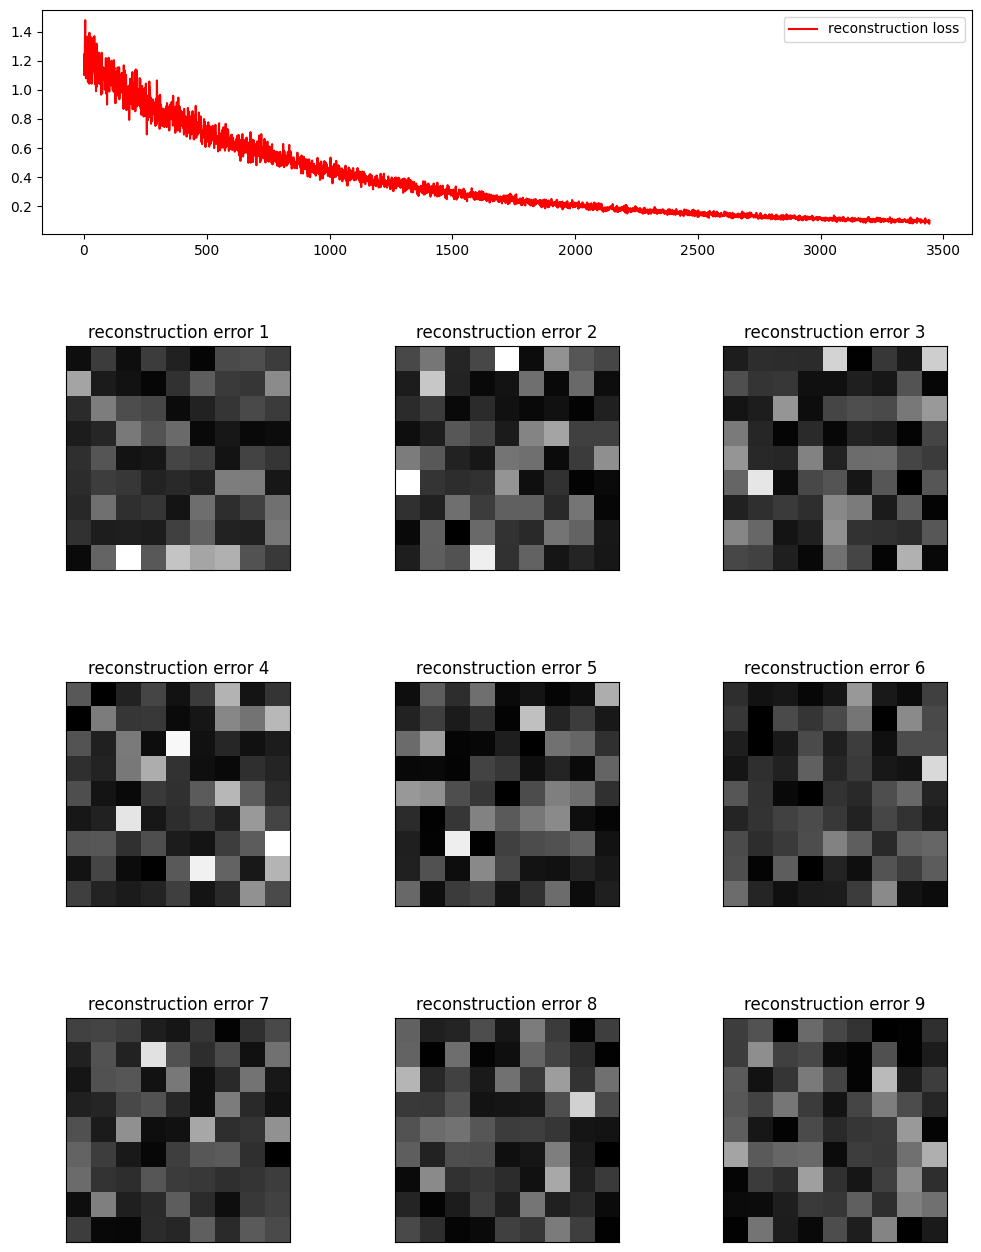

In [ ]:
# Delete this line if you're running this locally
log_dir = 'sudoku-blogpost'
# Visualize results
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tensorboard.backend.event_processing import event_accumulator
from PIL import Image
from io import BytesIO
plt.figure(figsize=(12, 16))
gs = GridSpec(4, 3, hspace=0.5)
axs = [plt.subplot(gs[0, :])] + [plt.subplot(gs[1+r, c]) for r in range(3) for c in range(3)]
img_accumulator = event_accumulator.EventAccumulator(log_dir, size_guidance={event_accumulator.IMAGES: 1}).Reload()
load_img = lambda i: np.asarray(Image.open(BytesIO(img_accumulator.Images(f'diff/{i}')[0].encoded_image_string)), dtype=int)
load_loss = lambda scalar: event_accumulator.EventAccumulator(f'{log_dir}/loss_{scalar}', size_guidance={event_accumulator.SCALARS: 0}).Reload().Scalars('loss')
axs[0].plot(list(map(lambda event: event.value, load_loss('mse'))), label='reconstruction loss', color='red')
axs[0].legend(loc='upper right')
for i in range(9):
    axs[1+i].imshow(load_img(i))
    axs[1+i].xaxis.set_visible(False)
    axs[1+i].yaxis.set_visible(False)
    axs[1+i].set_title(f'diff {i+1}')
plt.tight_layout()
plt.show()

## Results & discussion 
For reasons I'll get into in a moment, we can be relatively sure the model converges and will start to make correct predictions, but first I'd like to zoom out and get a bigger view of things. 

The difference between science fiction AI and the AI models we hear so much about today might be summarized by *counterfactual reasoning*; i.e. the ability to correctly answer 'what if?' questions. We often say that an AI is supposed to learn a 'model of the world', but what ends up happening is it learns a *passive* set of relationships in some data. What we really want is for it to learn cause and effect, with an *active* idea of how relationships change in response to things. (This is a distinction I borrow from *[GEB](https://en.wikipedia.org/wiki/G%C3%B6del,_Escher,_Bach)*, which I highly recommend everyone to read.). The connection between counterfactual reasoning and causal reasoning is well-known, to the point that some argue they are the same thing. And while the jury's still out as to [whether or not that's true](https://www.princeton.edu/~bkment/articles/causal%20reasoning.pdf), it can't be denied that it's an essential part of reasoning in general. We know from our sudoku generator that linear programs can get counterfactuality for free, being able to even tell you when your hypotheticals don't warrant a response and are infeasible.

We do have models that reason counterfactually in the continuous case. Variational autoencoders, for example, can give reasonable answers to [questions like "what's between a `9` and a `g`"](https://www.usna.edu/Users/cs/SD312/notes/18VAE/mnist.html). But their methods assume such answers are meaningful, when in fact this question is itself insane. This is a problem that's [baked pretty deep into the AI architectures](https://en.wikipedia.org/wiki/Embedding_(machine_learning)) of recent popularity, which work under similar assumptions. They all run gradient descent, with the justification that relationships between data can be approximated as continuous. However, we're finding that we don't like it when AI gives approximations, and the fact that they'd exist in machines as binary anyway makes this kind of a moot point.

We don't have an architecture that learns counterfactual reasoning in the discrete case, at least not satisfiably. It's hard to come up with one because gradient descent has been unreasonably effective and it's not clear what a purely discrete alternative looks like. But there might be workarounds. Instead of a discrete function, we could approximate the *boundary* of a related discrete set in some continuous way; this is the idea behind SudokuNet. In earlier drafts of this post I had the model learn 9x9 bitmasks representing rules, where for each bitmask the rule is 'cells a & b must contain different numbers if `bitmask[a] == 1` and `bitmask[b] == 1`'; i.e. `sum(bitmask * sudoku[:, :, d]) <= 1 for d in range(9)`. You might convince yourself that all the rules of sudoku can be represented like this, and an LP finding discrete solutions with the correct bitmask constraints would just be finding sudokus. In fact, restricting the possible rules this way gets you most of the way there. With some regularization (maximizing the number of 1's in a bitmask, making sure bitmasks are different from each other), a linear model will learn the correct masks without backpropagating through a linear program. This is part of the "key advantage of learning declaratively" as in [constrained conditional models](https://en.wikipedia.org/wiki/Constrained_conditional_model#Integer_linear_programming_for_natural_language_processing_applications), and is why our straightforwardly larger SudokuNet should converge; here it's very easy to learn the rules compared to memorizing all the examples. A constraint programming model learning sudoku isn't surprising, since it is a somewhat famous example of a game about constraints, but there does seem to be interesting potential here for situations that are "like sudoku if you squint through a stack of 128 neural networks". 

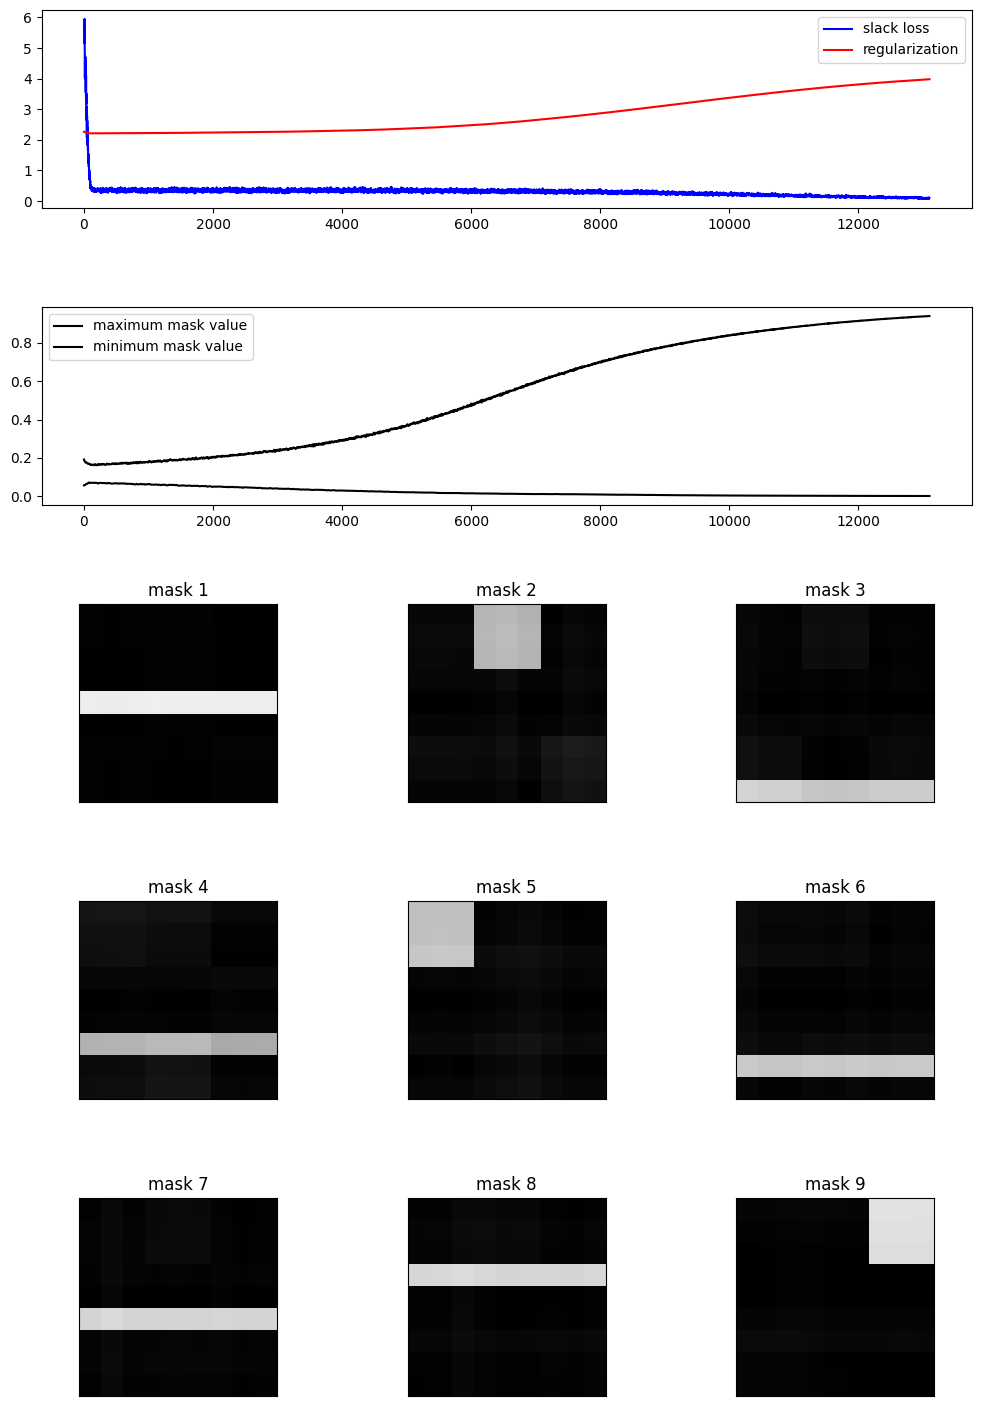

In [119]:
# Visualize results - old version
log_dir = 'sudoku-old'
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tensorboard.backend.event_processing import event_accumulator
from PIL import Image
from io import BytesIO
plt.figure(figsize=(12, 18))
gs = GridSpec(5, 3, hspace=0.5)
axs = [plt.subplot(gs[0, :]), plt.subplot(gs[1, :])] + [plt.subplot(gs[2+r, c]) for r in range(3) for c in range(3)]
img_accumulator = event_accumulator.EventAccumulator(log_dir, size_guidance={event_accumulator.IMAGES: 1}).Reload()
load_img = lambda i: np.asarray(Image.open(BytesIO(img_accumulator.Images(f'masks/{i}')[0].encoded_image_string)), dtype=int)
load_loss = lambda scalar: event_accumulator.EventAccumulator(f'{log_dir}/loss_{scalar}', size_guidance={event_accumulator.SCALARS: 0}).Reload().Scalars('loss')
load_range = lambda scalar: event_accumulator.EventAccumulator(f'{log_dir}/range_{scalar}', size_guidance={event_accumulator.SCALARS: 0}).Reload().Scalars('range')
axs[0].plot(list(map(lambda event: event.value, load_loss('slk'))), label='slack loss', color='blue')
axs[0].plot(list(map(lambda event: event.value, load_loss('reg'))), label='regularization', color='red')
axs[1].plot(list(map(lambda event: event.value, load_range('max'))), label='maximum mask value', color='black')
axs[1].plot(list(map(lambda event: event.value, load_range('min'))), label='minimum mask value', color='black')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper left')
for i in range(9):
    axs[2+i].imshow(load_img(i))
    axs[2+i].xaxis.set_visible(False)
    axs[2+i].yaxis.set_visible(False)
    axs[2+i].set_title(f'mask {i+1}')
plt.tight_layout()
plt.show()

Because constraint programming methods and discrete problems already have such a well-established relationship, gradient descent might end up looking sort of like wandering drunk at night when it comes to sample efficiency. For example, if you were able to determine not only if a constraint makes a solution infeasible, but *how many solutions it excludes if it is feasible*, you'd be able to greedily optimize for constraints that maximize this number, *i.e. the constraints that have the most importance to the problem*. There's some [recent work](https://arxiv.org/abs/2104.06407) related to this question, the volume of the set of solutions to a LP, that seems pretty interesting. 

I'll be trying to add a comments section soon, but if you'd like to discuss this post you can find my info on [my github](https://github.com/mxkopy). Thanks for reading!